# Samples analysis
Analyse cosmological model posterior samples.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1' # NOTE: jax preallocates GPU (default 75%)
import matplotlib.pyplot as plt
import numpy as np
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug, tree

from functools import partial
from getdist import plots
from numpyro import infer

%matplotlib inline
%load_ext autoreload
%autoreload 2

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload
from montecosmo.mcbench import sample_and_save

# import mlflow
# mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")
# mlflow.set_experiment("infer")
# !jupyter nbconvert --to script ./src/montecosmo/tests/infer_model.ipynb

2024-12-15 11:11:52.266814: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [48]:
list({1,2} -{2})

[1]

In [66]:
set([2])

{2}

In [ ]:
from montecosmo.mcbench import Samples

zzz = {'a':np.array([2,3]), 'b':np.array([4,5]), 'c':np.array([6,7])}
gs = {'gab':['a','b'], 'ga':['a']}
aaa = Samples(zzz, gs)
aaa['gab']

In [27]:
'*~gab'.startswith('*~')

True

In [3]:
from collections import UserDict
from montecosmo.mcbench import Chains, Samples

from dataclasses import asdict, fields

zzz = {'a':np.array([2,3]), 'b':np.array([4,5])}
zzz2 = {'a':np.array([2,3]), 'b':np.array([4,5])}
# zzz2 = {'a':['a'], 'b':['b']}
zzz = {'a':[5,3], 'b':[4,5]}
zzz2 = {'a':['a','b'], 'd':['a','b']}
# aaa = UserDict(zzz)
aaa = Chains(zzz, groups=zzz2)

# bbb = aaa.copy(),
import copy
# bbb = copy.copy(aaa)
bbb = aaa.copy()
# bbb = type(aaa)(**asdict(aaa))
# bbb.data['a'][0] = 0
# bbb.groups['a'][0] = 0

bbb.data['a'] = 0
bbb.groups['a'] = 0
aaa, bbb

1
<class 'montecosmo.mcbench.Chains'>
3
<class 'montecosmo.mcbench.Chains'>


(Chains(data={'a': [5, 3], 'b': [4, 5]}, groups={'a': 0, 'd': ['a', 'b']}, labels={}),
 Chains(data={'a': 0, 'b': [4, 5]}, groups={'a': 0, 'd': ['a', 'b']}, labels={}))

## Config and fiduc

Loading truth from /feynman/home/dphp/hs276503/scratch/pickles/m64_b320.0_al0.1_ao0.5_lo1_pc1_obmesh/


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

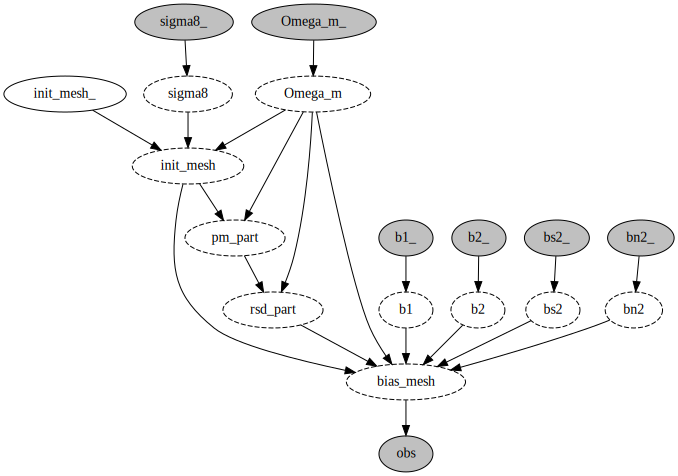

In [8]:
import argparse

def get_save_dir(**kwargs):
    dir = os.path.expanduser("~/scratch/pickles/")
    # dir = os.path.expanduser("/lustre/fsn1/projects/rech/fvg/uvs19wt/pickles/")

    dir += f"m{kwargs['mesh_shape'][0]:d}_b{kwargs['box_shape'][0]:.1f}"
    dir += f"_al{kwargs['a_lpt']:.1f}_ao{kwargs['a_obs']:.1f}_lo{kwargs['lpt_order']:d}_pc{kwargs['precond']:d}_ob{kwargs['obs']}/"
    return dir

def create_parser():
    parser = argparse.ArgumentParser(description='Parse configuration parameters.')
    parser.add_argument('-m', '--mesh_length', type=int, help='Mesh length')
    parser.add_argument('-b', '--box_length', type=float, help='Box length', default=None)
    parser.add_argument('-al', '--a_lpt', type=float, help='a lpt', default=0.1)
    parser.add_argument('-ao', '--a_obs', type=float, help='a obs', default=0.5)
    parser.add_argument('-lo', '--lpt_order', type=int, help='lpt order')
    parser.add_argument('-pc', '--precond', type=int, help='preconditioning')
    parser.add_argument('-o', '--obs', type=str, help='observable type', default='mesh')
    return parser


config = {
          'mesh_shape':3 * (64,),
          'box_shape':3 * (320.,),
          'a_lpt':0.1,
          'a_obs':0.5,
          'lpt_order':1,
          'precond':1,
          'obs':'mesh'
          }

# parser = create_parser()
# args = parser.parse_args()
# config = {
#           'mesh_shape':3 * (args.mesh_length,),
#           'box_shape':3 * (args.box_length if args.box_length is not None else 5 * args.mesh_length,), 
#           'a_lpt':args.a_lpt if args.lpt_order > 0 else args.a_obs,
#           'a_obs':args.a_obs,
#           'lpt_order':args.lpt_order,
#           'precond':args.precond,
#           'obs':args.obs
#           }


save_dir = get_save_dir(**config)
model = FieldLevelModel(**default_config | config)
# print(model)
# model.render(0,1)

if not os.path.exists(save_dir):
    # Predict and save fiducial
    truth = {'Omega_m': 0.31, 
            'sigma8': 0.81, 
            'b1': 1., 
            'b2':0., 
            'bs2':0., 
            'bn2': 0.}

    model.reset()
    truth = model.predict(samples=truth, hide_base=False, frombase=True)
    
    print(f"Saving model and truth at {save_dir}")
    os.mkdir(save_dir)
    model.save(save_dir)    
    pdump(truth, save_dir + "truth.p")
else:
    print(f"Loading truth from {save_dir}")
    truth = pload(save_dir + "truth.p")

model.condition({'obs': truth['obs']} | model.prior_loc, frombase=True)
if model.precond==3:
    model.obs_meshk = truth['obs']
# model.block()
model.render(0,1)

In [12]:
model.predict(hide_base=False)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

{'Omega_m_': Array(-0.13291842, dtype=float32),
 'sigma8_': Array(-3.197303e-05, dtype=float32),
 'Omega_m': Array(0.3111, dtype=float32),
 'sigma8': Array(0.8102, dtype=float32),
 'b1_': 0.0,
 'b2_': 0.0,
 'bs2_': 0.0,
 'bn2_': 0.0,
 'b1': 1.0,
 'b2': 0.0,
 'bs2': 0.0,
 'bn2': 0.0,
 'init_mesh_': Array([[[-1.23770916e+00, -1.62268057e-01, -6.63358331e-01, ...,
           1.30648327e+00, -1.30309570e+00, -1.05513501e+00],
         [ 7.85721540e-01,  2.29968652e-01,  9.12788451e-01, ...,
          -4.25435632e-01, -1.99697459e+00,  1.01106322e+00],
         [ 8.59515190e-01,  8.64170372e-01, -3.61370146e-02, ...,
          -1.37090611e+00, -2.82141924e-01,  4.54826325e-01],
         ...,
         [-1.42707002e+00, -5.30050397e-01, -6.87824726e-01, ...,
           9.91508484e-01,  3.81552249e-01, -1.06915794e-01],
         [ 2.70522332e+00,  2.45602235e-01, -3.60710174e-01, ...,
           1.03109157e+00,  1.02881938e-01, -6.62917137e-01],
         [-6.78819478e-01, -1.03480732e+00, -1.6

## Analysis

In [ ]:
from montecosmo.mcbench import Chains
save_path = save_dir+"sNUTS_nc8_ns64_10_0.8"

transforms = [lambda x:x[['cosmo_','bias_']], partial(model.thin_chains, thinning=1), model.reparam_chains, partial(model.choice_chains, rng=42, n=10)]
chains = model.load_runs(save_path, 1,10, transforms=transforms, batch_ndim=2)
last_state = pload(save_path + "_last_state.p")
print("mean_acc_prob:", last_state.mean_accept_prob, "\nss:", last_state.adapt_state.step_size)
chains.shape

In [3]:
shape = (2,20)
jfn = jit(partial(model.predict, samples=shape))
params = jfn(jr.key(42))
params |= {"n_evals":jnp.ones(shape)}
jnp.savez(save_dir + "samples_0", **params)
params = jfn(jr.key(43))
params |= {"n_evals":2*jnp.ones(shape)}
jnp.savez(save_dir + "samples_1", **params)
params = jfn(jr.key(44))
params |= {"n_evals":3*jnp.ones(shape)}
jnp.savez(save_dir + "samples_2", **params)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

In [5]:
from montecosmo.mcbench import Chains, Samples


transforms = [lambda x:x[['*~obs']], 
              partial(Chains.thin, thinning=1), 
              model.reparam_chains, 
              partial(Chains.choice, n=10)]
chains = model.load_runs(save_dir+"samples", 0,2, transforms=transforms, batch_ndim=2)
chains.shape

Loading: samples, from run 0 to run 2 (included)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


{'Omega_m': (2, 60),
 'Omega_m_': (2, 60),
 'b1': (2, 60),
 'b1_': (2, 60),
 'b2': (2, 60),
 'b2_': (2, 60),
 'bn2': (2, 60),
 'bn2_': (2, 60),
 'bs2': (2, 60),
 'bs2_': (2, 60),
 'init_mesh': (2, 60, 10),
 'init_mesh_': (2, 60, 10),
 'n_evals': (2, 60),
 'obs': (2, 60, 64, 64, 64),
 'sigma8': (2, 60),
 'sigma8_': (2, 60)}

In [181]:
chains.stack(['cosmo'])

KeyError: 'cosmo'

In [11]:
aaa

Chains(data={'a': ([5, 3], [4, 5]), 'b': (([5, 3], [4, 5]), [4, 5])}, groups={'a': ['a', 'b'], 'b': ['a', 'b']}, labels={})

In [43]:
fields(aaa)

(Field(name='data',type=<class 'dict'>,default=<dataclasses._MISSING_TYPE object at 0x7ffff5cfdb20>,default_factory=<dataclasses._MISSING_TYPE object at 0x7ffff5cfdb20>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='groups',type=<class 'dict'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7ffff5cfdb20>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD),
 Field(name='labels',type=<class 'dict'>,default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7ffff5cfdb20>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),kw_only=False,_field_type=_FIELD))

In [34]:
aaa = Samples(zzz)

# ccc = asdict(aaa)
# ccc['data']['a'][0] = 4
ccc = dict(aaa.data)
ccc['a'][0] = 4
aaa, ccc

(Samples(data={'a': [4, 3], 'b': [4, 5]}, groups={}),
 {'a': [4, 3], 'b': [4, 5]})

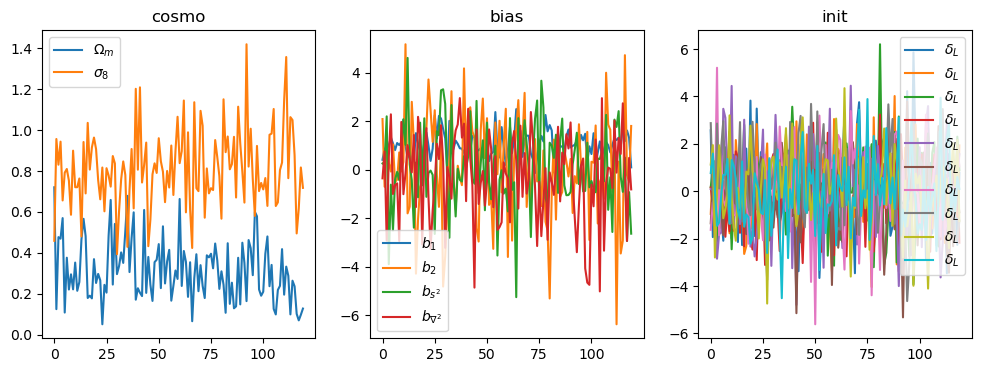

In [150]:
plt.figure(figsize=(12,4))
chains.plot(['cosmo', 'bias','init'])
# chains.print_summary()

Removed no burn in


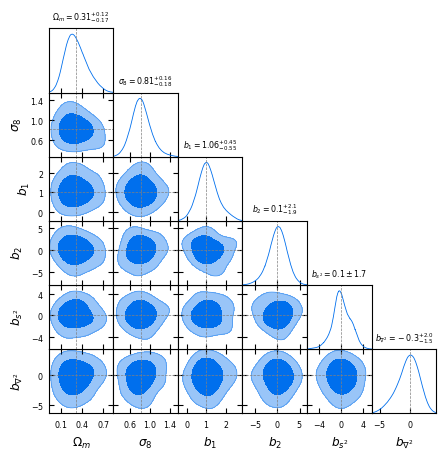

In [47]:
gdsamp = chains[['cosmo','bias']].to_getdist()

gdplt = plots.get_subplot_plotter(width_inch=5)
gdplt.triangle_plot(roots=[gdsamp],
                title_limit=1,
                filled=True, 
                markers=truth,)

In [125]:
length = 10
aaa = jnp.arange(100).reshape(2,50)
n = 50

def cumfn_array(a, fn, n, *args, axis=0):
    filt_ends = jnp.rint(jnp.arange(1,n+1) / n * a.shape[axis]).astype(int)
    print(filt_ends)
    filt_fn = lambda end: fn(a[axis*(slice(None),) + (slice(None,end),)], *args)
    out = []
    for end in filt_ends:
        out.append(filt_fn(end))
    return jnp.stack(out, axis=axis)

def cumfn(chains, fn, n, *args, batch_ndim=2):
    axis = max(batch_ndim-1, 0)
    name = "n_evals"
    if name in chains:
        infos, rest = chains[[name], ['~'+name]]
        sum_fn = lambda x: cumfn_array(x, jnp.sum, n, axis=axis)
        infos = tree.map(sum_fn, infos)
    else:
        rest = chains
        infos = {}

    thin_fn = lambda x: cumfn_array(x, fn, n, *args, axis=axis)
    return infos | tree.map(thin_fn, rest)

cumfn_array(aaa, lambda x: jnp.sum(x, axis=1), n, axis=1), jnp.cumsum(aaa, axis=1), aaa

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


(Array([[   0,    1,    3,    6,   10,   15,   21,   28,   36,   45,   55,
           66,   78,   91,  105,  120,  136,  153,  171,  190,  210,  231,
          253,  276,  300,  325,  351,  378,  406,  435,  465,  496,  528,
          561,  595,  630,  666,  703,  741,  780,  820,  861,  903,  946,
          990, 1035, 1081, 1128, 1176, 1225],
        [  50,  101,  153,  206,  260,  315,  371,  428,  486,  545,  605,
          666,  728,  791,  855,  920,  986, 1053, 1121, 1190, 1260, 1331,
         1403, 1476, 1550, 1625, 1701, 1778, 1856, 1935, 2015, 2096, 2178,
         2261, 2345, 2430, 2516, 2603, 2691, 2780, 2870, 2961, 3053, 3146,
         3240, 3335, 3431, 3528, 3626, 3725]], dtype=int32),
 Array([[   0,    1,    3,    6,   10,   15,   21,   28,   36,   45,   55,
           66,   78,   91,  105,  120,  136,  153,  171,  190,  210,  231,
          253,  276,  300,  325,  351,  378,  406,  435,  465,  496,  528,
          561,  595,  630,  666,  703,  741,  780,  820,  861,  903,

In [71]:
def truc(a=1, b=2):
    print(a,b)

tree.map(truc, a=1, b=2)


TypeError: tree_map() got an unexpected keyword argument 'a'

In [53]:
jnp.rint(jnp.arange(1,n+1)/n*length).astype(int)

Array([2], dtype=int32)

In [ ]:
meshes = []
for pc in [0,1,2,3]:
    dir = get_save_dir(**model.__dict__ | {'precond':pc})
    # mesh = jnp.fft.irfftn(pload(dir + "truth.p")['init_mesh'])
    mesh = pload(dir + "truth.p")['obs']
    meshes.append(mesh)